#**ORIE 4580 Final Report**

In [ ]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

!git clone https://github.com/sdevling/ORIE_4580_Final_Project.git
sys.path.append('/content/ORIE_4580_Final_Project')
BASE = "/content/ORIE_4580_Final_Project"

fatal: destination path 'ORIE_4580_Final_Project' already exists and is not an empty directory.


#**Executive Summary**

Modern Large Language Model serving systems must handle maximizing GPU throughput while maintaining low latency for the user. We have developed a simulation framework to study how different ways of organizing and processing requests affect both system efficiency and user experience. In particular, the model focuses on two essential stages of an LLM response, prefill and decode. Prefill refers to processing the user’s prompt, and decode refers to generating the response one token at a time. Our model captures how GPUs behave in practice by accounting for the time it takes to start a batch and the additional time needed to process each token.<br>


Using our simulation, we compare how several scheduling and batching strategies influence three key performance metrics: how many queries the system can handle per second (throughout), how long users wait before seeing the first response token (time to first token/TTFT), and the latency between tokens the first one is generated (time between tokens /TBT). We examine three scheduling policies, serving one query at a time until completion (decode-prioritizing), favoring prompt processing across multiple active queries (pre-fill prioritizing), and a hybrid approach that groups queries into batches. This comparison reveals clear trade-offs among the policies. Serving queries one at a time results in low throughput and rapidly increasing latency as arrival rates grow. Priorizing prompt processing improves overall throughput and allows the system to sustain higher request rates, but it can increase delays in response generation under a heavy workload. Since hybrid policies sit between the other two approaches, they can be adjusted to balance throughput, latency, and fairness.<br>


Furthermore, we then analyze workload sensitivity by simulating light, mixed, and heavy workloads that differ in prompt length and response size. Light workloads with short prompt allow the system to sustain higher arrival rates, while mixed and heavy workloads place greater demands on GPU resources. As a result, heavier workloads overload the system more quickly and lead to larger delays, highlighting the need for scheduling strategies that align with expected usage patterns.
Finally, we study the effect of batching, which allows the system to process multiple tokens together. We compare three cases: no batching, fixed batching, and dynamic batching. <br>


Batching significantly improves throughput by reducing repeated setup costs on the GPU; however, fixed batching increases TTFT by forcing queries to wait for larger batches to form. Dynamic batching performs best overall, because it adapts to this by forming batches based on queue depth and waiting time. This preserves most of the efficiency while reducing tail latency.<br>


Overall, our model and analysis show that small changes in batching and scheduling logic can lead to large improvements in throughput and latency. The simulation framework is a practical tool for understanding these trade-offs and for guiding decisions in real-world LLM serving systems.


# **I. Comparing Different Scheduling Policies**

### Overview



To explore the impact of queuing policy on the system's processing ability, a policy interface was created to provide the baseline structure for each policy class. A policy decides which queries are selected for each GPU batch, how many tokens from each query are included, the batch's functionality (prefill vs. decode), and when the batch is dispatched to the GPU worker. Each policy class contains the *dispatch_batch* method, which determines the above characteristics. Policies are limited by K, the maximum number of tokens allowed in one batch. All policies operate under the same GPU worker that processes tokens with an estimated service time of (c + a * max(0, number of tokens in batch - b0)). B0 in this calculation is the minimum batch size threshold. Incoming queries were all generated with L prefill tokens and B decode tokens. To reduce the potential for confounding variables, the following parameters were kept stable during all policy simulations: L = 64, B = 32, c = 40 ms, a = 0.3 ms, b0 = 64, K = 128. For the purposes of this exploration, three different policies were tested and are listed below:



1.  **Decode Prioritizing** - Queries are served one at a time until completed.
2.  **Prefill Prioritizing** - Query prefill tokens are processed first. The system only begins processing decode tokens when no prefill work remains.
3.  **Hybrid** - Queries are grouped into batches of size Q queries. Within each batch, all prefill tokens are processed first, then decode tokens. The system does not begin processing a new batch until all queries in the previous batch have been completed.


### Model Details

**Decode Prioritizing Policy**

The decode prioritizing policy was implemented using the *ServeToCompletionPolicy* class. This class selects the earliest-arriving query, processes its prefill tokens first, then processes its decode tokens. The class does not batch across queries and decodes one token at a time. This functionality utilizes two lists of queries: prefill_queue and decode_queue. When a query enters the system, it is placed in the prefill queue. The query's prefill tokens are processed first, then the query is removed from the prefill queue and joins the decode queue. After this, the query's decode tokens are processed. The query is then removed from the decode queue and exits the system.  

**Prefill Prioritizing Policy**

The prefill prioritizing policy was implemented using the *PrefillFirstPolicy* class. This class also uses prefill_queue and decode_queue to organize system work. As queries enter the system, they are placed in the prefill queue. Prefill tokens from all queries in prefill_queue are processed first. When the prefill queue is empty, the system then begins processing tokens from the queries in decode_queue. Decoding tokens are added to a batch for GPU processing (with at most 1 decode token per query in each batch). After processing each decode batch, the class checks for prefill work before assigning another decode batch to the GPU.

**Hybrid Policy**

The hybrid policy was implemented using the *HybridSchedulerPolicy* class. This class groups queries into an active batch of at most Q queries. When the active batch is empty, the class selects up to Q additional queries from the prefill and decode queues and adds it to the batch. Active batch queries are processed to completion with prefill-priority. Once all active queries have finished both their prefill and decode phases, the active batch resets and new one is chosen. Q was set at 15 for all simulations below.

### Model Analysis

To analyze the behavior of each scheduling policy, 3 performance metrics were chosen. These metrics are throughput (the rate at which queries pass through the system), time to first token (latency until first response), and time between tokens (latency between successive tokens). The simulation was ran for 3000 queries under each scheduling policy for a series of arrival rates between 0.1 and 10 query arrivals per second. Results were output into the file *policy_testing_results_3000.csv* and can be visualized below.

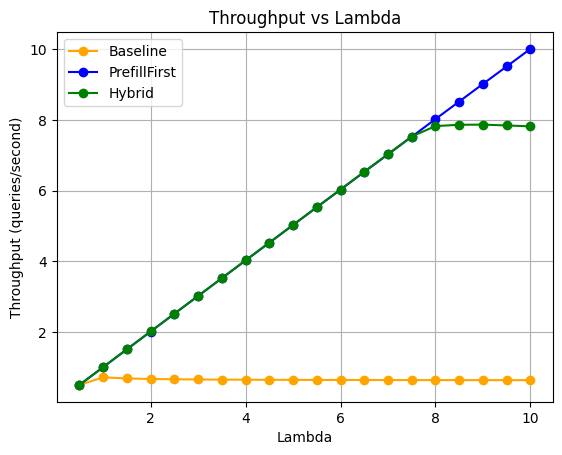

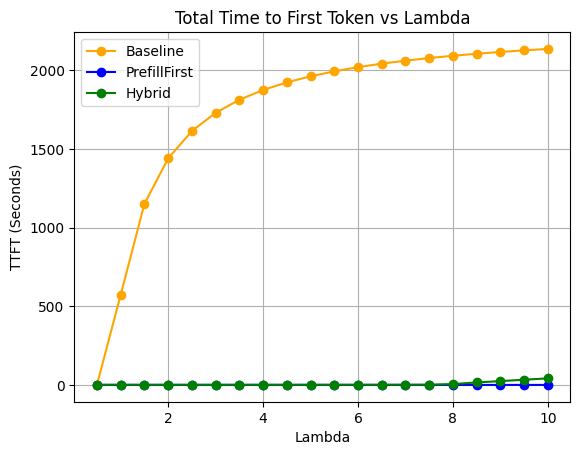

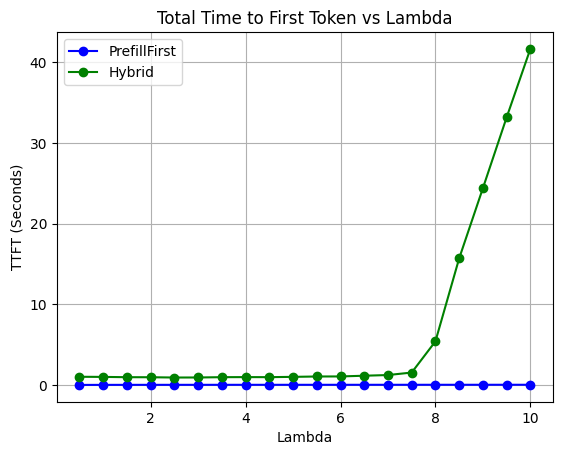

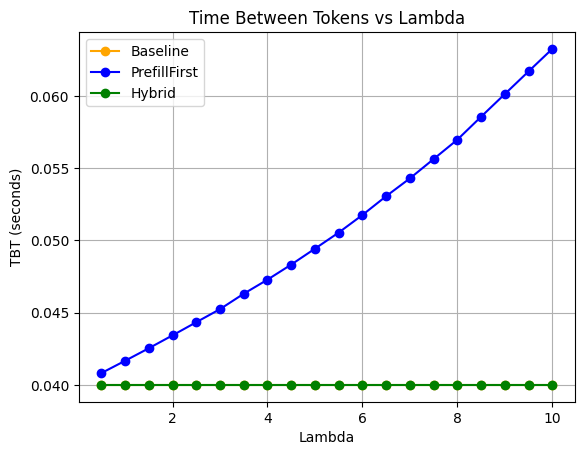

In [ ]:
#import data
url = "https://raw.githubusercontent.com/sdevling/ORIE_4580_Final_Project/main/policy_testing_results_3000.csv"
df_policy3000 = pd.read_csv(url)
df_policy3000.head()


#Plot throughput vs. lambda for each scheduling policy
plt.figure()
plt.plot(df_policy3000["Lambda"], df_policy3000["Baseline throughput"], marker='o', label="Baseline", color = "orange")
plt.plot(df_policy3000["Lambda"], df_policy3000["PrefillFirst throughput"], marker='o', label="PrefillFirst", color = "blue")
plt.plot(df_policy3000["Lambda"], df_policy3000["Hybrid throughput"], marker='o', label="Hybrid", color = "green")

plt.xlabel("Lambda")
plt.ylabel("Throughput (queries/second)")
plt.title("Throughput vs Lambda")
plt.legend()
plt.grid(True)
plt.show()

#Plot TTFT vs. lambda for each scheduling policy
plt.figure()
plt.plot(df_policy3000["Lambda"], df_policy3000["Baseline ttft"], marker='o', label="Baseline", color = "orange")
plt.plot(df_policy3000["Lambda"], df_policy3000["PrefillFirst ttft"], marker='o', label="PrefillFirst", color = "blue")
plt.plot(df_policy3000["Lambda"], df_policy3000["Hybrid ttft"], marker='o', label="Hybrid", color = "green")

plt.xlabel("Lambda")
plt.ylabel("TTFT (Seconds)")
plt.title("Total Time to First Token vs Lambda")
plt.legend()
plt.grid(True)
plt.show()

#Plot TTFT vs, lambda just for PrefillFirst vs. Hybrid
plt.figure()
plt.plot(df_policy3000["Lambda"], df_policy3000["PrefillFirst ttft"], marker='o', label="PrefillFirst", color = "blue")
plt.plot(df_policy3000["Lambda"], df_policy3000["Hybrid ttft"], marker='o', label="Hybrid", color = "green")

plt.xlabel("Lambda")
plt.ylabel("TTFT (Seconds)")
plt.title("Total Time to First Token vs Lambda")
plt.legend()
plt.grid(True)
plt.show()

#Plot TBT vs, lambda
plt.figure()
plt.plot(df_policy3000["Lambda"], df_policy3000["Baseline tbt"], marker='o', label="Baseline", color = "orange")
plt.plot(df_policy3000["Lambda"], df_policy3000["PrefillFirst tbt"], marker='o', label="PrefillFirst", color = "blue")
plt.plot(df_policy3000["Lambda"], df_policy3000["Hybrid tbt"], marker='o', label="Hybrid", color = "green")

plt.xlabel("Lambda")
plt.ylabel("TBT (seconds)")
plt.title("Time Between Tokens vs Lambda")
plt.legend()
plt.grid(True)
plt.show()

NOTE: In the TBT graph, TBT values for the Baseline and Hybrid Policies are equal, so the baseline values get covered by the Hybrid values on the graph above.

Analysis of the plots above reveals key differences between the three scheduling policies. As lambda increases from 0.1 to 10 query arrivals per second, both the hybrid and baseline (decode-prioritizing) policies reach a throughput limit. The maximum recorded throughput for the baseline policy is achieved at around 0.72 queries/second. For the hybrid policy, it is achieved at approximately 7.87 queries/second. However, it is important to note that lower Q values would yield lower throughput and higher Q values would yield higher throughput (more similarly distributed to prefill-priority). This makes sense when considering the outer limits of Q (Q=1 implements a decode prioritizing policy and Q = $\infty$ implements a prefill prioritizing policy). For the range of lambda arrivals, the prefill priority policy throughput continues to rise, suggesting that the system throughput can continue to rise beyond its maximum recorded value of 10.0. When stable, total time to first token is higher for the hybrid and baseline policies because an incoming queue must wait for the previous queues/batches to finish decoding before it is able to start prefill. At max throughput, ttft grows unbounded. For the baseline policy, this happens at low arrival rates (lambda ≳ 1). For the hybrid policy, this happens at a greater arrival rate (lambda ≳ 8), and even greater for prefill-first. Time between tokens remains steady at 0.04 for the baseline and hybrid policies because decode tokens for a batch/query are completely processed before beginning more prefill work. For the prefill-first policy, tbt grows with arrival rate because incoming queries disrupt the processing of decode tokens.

### Conclusions

For systems with high query arrival rates, prefill-first priority is the best option because it maintains high throughput. However, a hybrid policy with Q set to a high value can maintain similar effect. In cases where all policies can maintain stable processing and low latency between successive tokens is desired, prefill-first or hybrid policies are best because they maintain TBT at a value equal to c.

# **II. Workload Sensitivity Analysis**

### Overview

To study how prompt length (prefill) and output length (decode) affect throughput and latency, we defined three stochastic workloads representing light, mixture, and heavy queries. For each workload, we evaluated system performance across a range of arrival rates. We compared a serve-to-completion baseline with the prefill-first policy, which performed best in earlier experiments, to examine how workload characteristics and scheduling decisions influence throughput and tail latency.

### Workload Generation

**Light Workload**<br>
Prefill lengths are drawn uniformly from 8–64 tokens, and decode lengths follow a geometric distribution (p = 0.25) capped at 32 tokens.

In [ ]:
#Functions that generate a random light workload (low prefill and decode lengths)
def L_short():
    return np.random.randint(8, 64)

def B_short(Li):
    return min(np.random.geometric(0.25), 32)

**Mixture Workload**

Prefill lengths are sampled from a three-component mixture: short (8–64 tokens, 60%), medium (64–256 tokens, 30%), and long (256–1024 tokens, 10%). Decode lengths are conditionally sampled based on prefill size, with larger prefills inducing larger decode distributions.

In [ ]:
#Functions that generate a random mixed prefill length and a mixed decode
#length based on the prefill length
def L_mixture():
    bucket = np.random.choice([0,1,2], p=[0.6, 0.3, 0.1])
    if bucket == 0:
        return np.random.randint(8, 64)
    elif bucket == 1:
        return np.random.randint(64, 256)
    else:
        return np.random.randint(256, 1024)

def B_mixture(Li):
    if Li < 64:
        return min(np.random.geometric(0.25), 32)
    elif Li < 256:
        return min(np.random.geometric(0.15), 64)
    else:
        return min(np.random.geometric(0.10), 128)

**Heavy Workload**<br>
Prefill lengths follow a two-component mixture, with most prompts being short-to-moderate (16–128 tokens, 85%) and a minority being long (512–2048 tokens, 15%). Decode lengths are conditionally sampled based on prefill size using heavier-tailed geometric distributions and larger caps for long prompts.

In [ ]:
#Functions that generate a random heavy prefill length and a heavy decode
#length based on prefill length
def L_heavy():
    if np.random.random() < 0.85:
        return np.random.randint(16, 128)
    else:
        return np.random.randint(512, 2048)

def B_heavy(Li):
    if Li < 128:
        return min(np.random.geometric(0.2), 64)
    else:
        return min(np.random.geometric(0.08), 256)

### Simulation Process

For both scheduling policies, we simulated all three workloads across a range of arrival rates, lambda. For each workload, lambda was gradually increased until the system became overloaded and could no longer keep up with incoming queries. In practice, overload was indicated by the simulation taking an unreasonably long time to run, such as running for several hours without producing results.

### Results

In [ ]:
#@title Import Data
!git clone https://github.com/sdevling/ORIE_4580_Final_Project.git
sys.path.append('/content/ORIE_4580_Final_Project')

BASE = "/content/ORIE_4580_Final_Project"

df_short_stc   = pd.read_csv(f"{BASE}/short_workload_2.csv")
df_mixture_stc = pd.read_csv(f"{BASE}/mixture_workload_2.csv")
df_heavy_stc   = pd.read_csv(f"{BASE}/heavy_workload_2.csv")

df_short_pf   = pd.read_csv(f"{BASE}/short_workload (3).csv")
df_mixture_pf = pd.read_csv(f"{BASE}/mixture_workload (3).csv")
df_heavy_pf  = pd.read_csv(f"{BASE}/heavy_workload (3).csv")

fatal: destination path 'ORIE_4580_Final_Project' already exists and is not an empty directory.


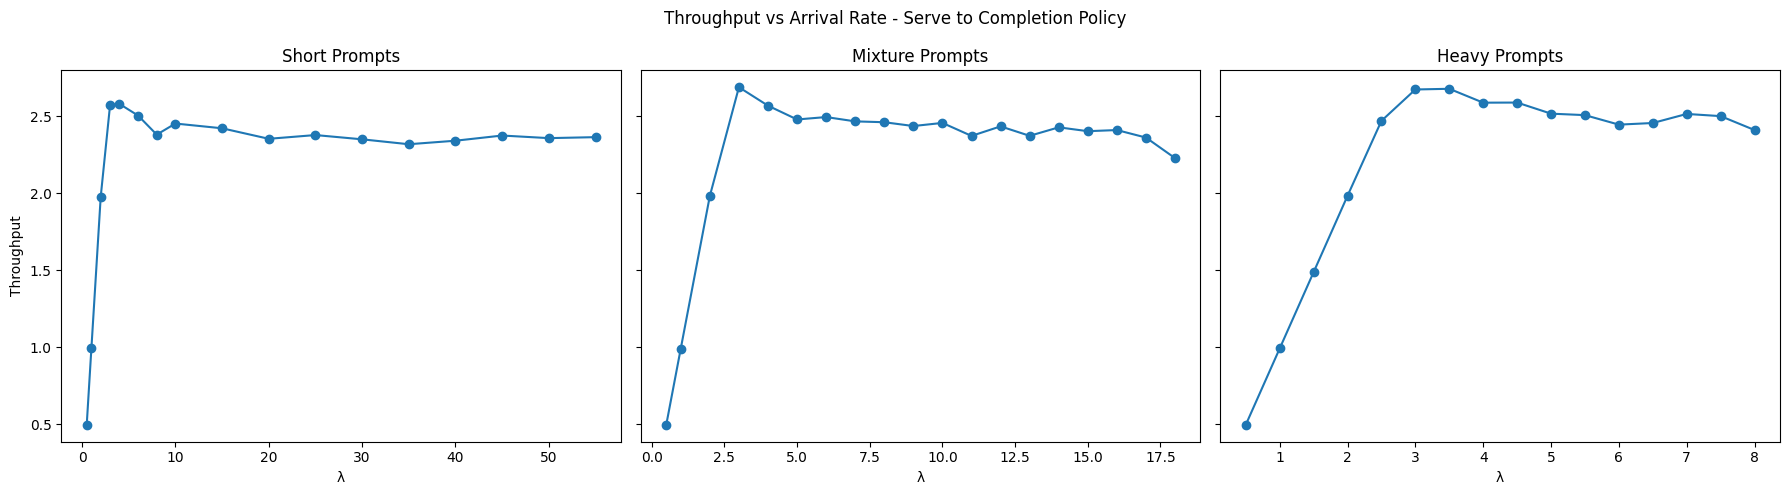

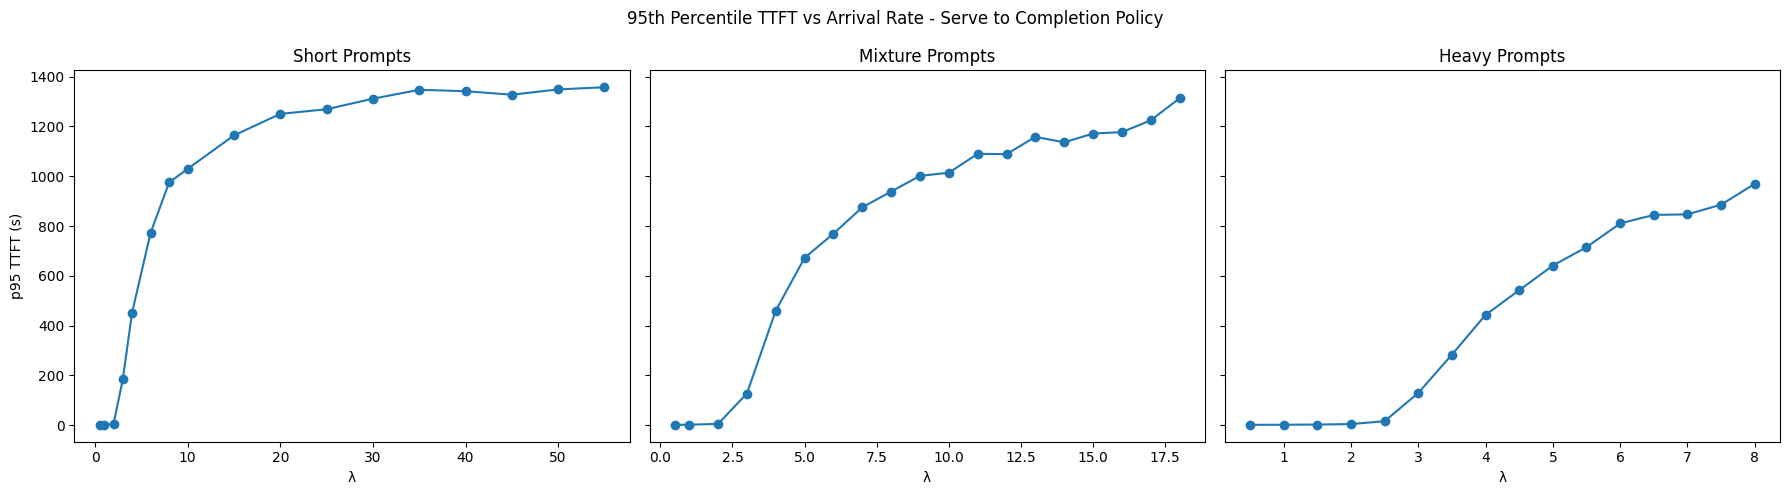

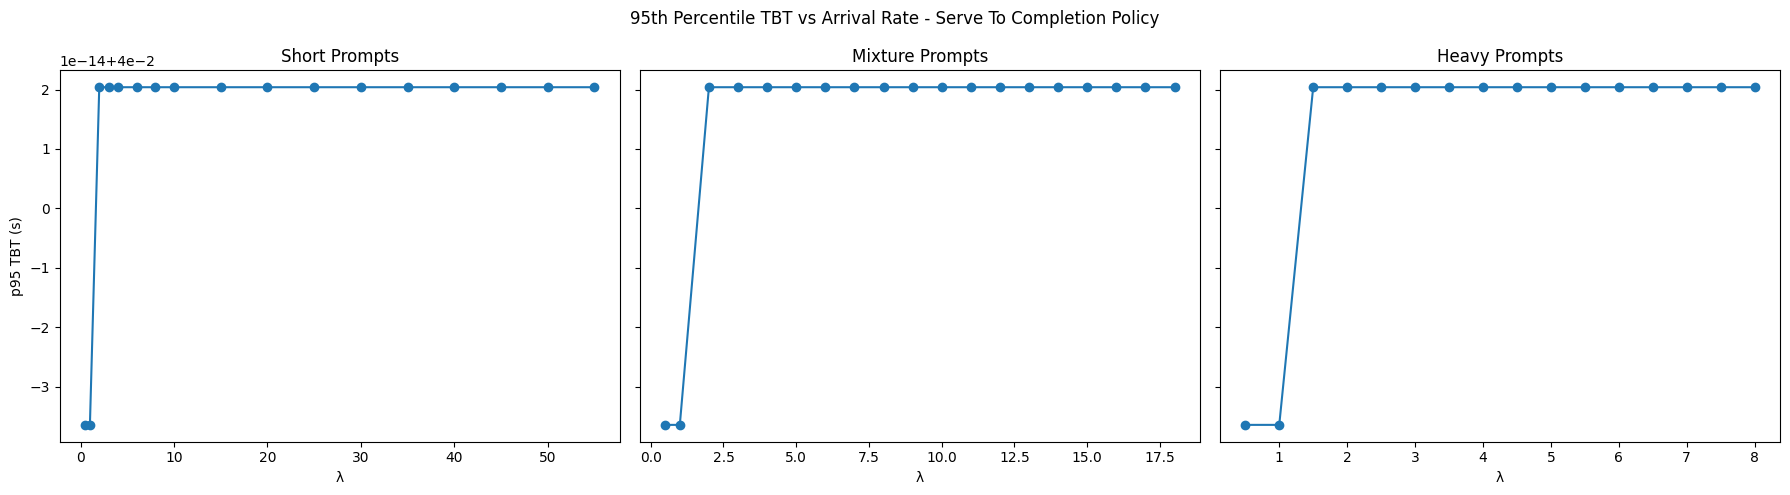

In [ ]:
#@title Plots For Serve to Completion Policy
#Plots the results of analysis for the serve to completion policy

#Throughput
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

axes[0].plot(df_short_stc["lambda"], df_short_stc["throughput"], marker="o")
axes[0].set_title("Short Prompts")
axes[0].set_xlabel("λ")
axes[0].set_ylabel("Throughput")

axes[1].plot(df_mixture_stc["lambda"], df_mixture_stc["throughput"], marker="o")
axes[1].set_title("Mixture Prompts")
axes[1].set_xlabel("λ")

axes[2].plot(df_heavy_stc["lambda"], df_heavy_stc["throughput"], marker="o")
axes[2].set_title("Heavy Prompts")
axes[2].set_xlabel("λ")

plt.suptitle("Throughput vs Arrival Rate - Serve to Completion Policy")
plt.tight_layout()
plt.show()

#95th Percentile TTFT
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

axes[0].plot(df_short_stc["lambda"], df_short_stc["p95_ttft"], marker="o")
axes[0].set_title("Short Prompts")
axes[0].set_xlabel("λ")
axes[0].set_ylabel("p95 TTFT (s)")

axes[1].plot(df_mixture_stc["lambda"], df_mixture_stc["p95_ttft"], marker="o")
axes[1].set_title("Mixture Prompts")
axes[1].set_xlabel("λ")

axes[2].plot(df_heavy_stc["lambda"], df_heavy_stc["p95_ttft"], marker="o")
axes[2].set_title("Heavy Prompts")
axes[2].set_xlabel("λ")

plt.suptitle("95th Percentile TTFT vs Arrival Rate - Serve to Completion Policy")
plt.tight_layout()
plt.show()

#95th Percentile TBT
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

axes[0].plot(df_short_stc["lambda"], df_short_stc["p95_tbt"], marker="o")
axes[0].set_title("Short Prompts")
axes[0].set_xlabel("λ")
axes[0].set_ylabel("p95 TBT (s)")

axes[1].plot(df_mixture_stc["lambda"], df_mixture_stc["p95_tbt"], marker="o")
axes[1].set_title("Mixture Prompts")
axes[1].set_xlabel("λ")

axes[2].plot(df_heavy_stc["lambda"], df_heavy_stc["p95_tbt"], marker="o")
axes[2].set_title("Heavy Prompts")
axes[2].set_xlabel("λ")

plt.suptitle("95th Percentile TBT vs Arrival Rate - Serve To Completion Policy")
plt.tight_layout()
plt.show()

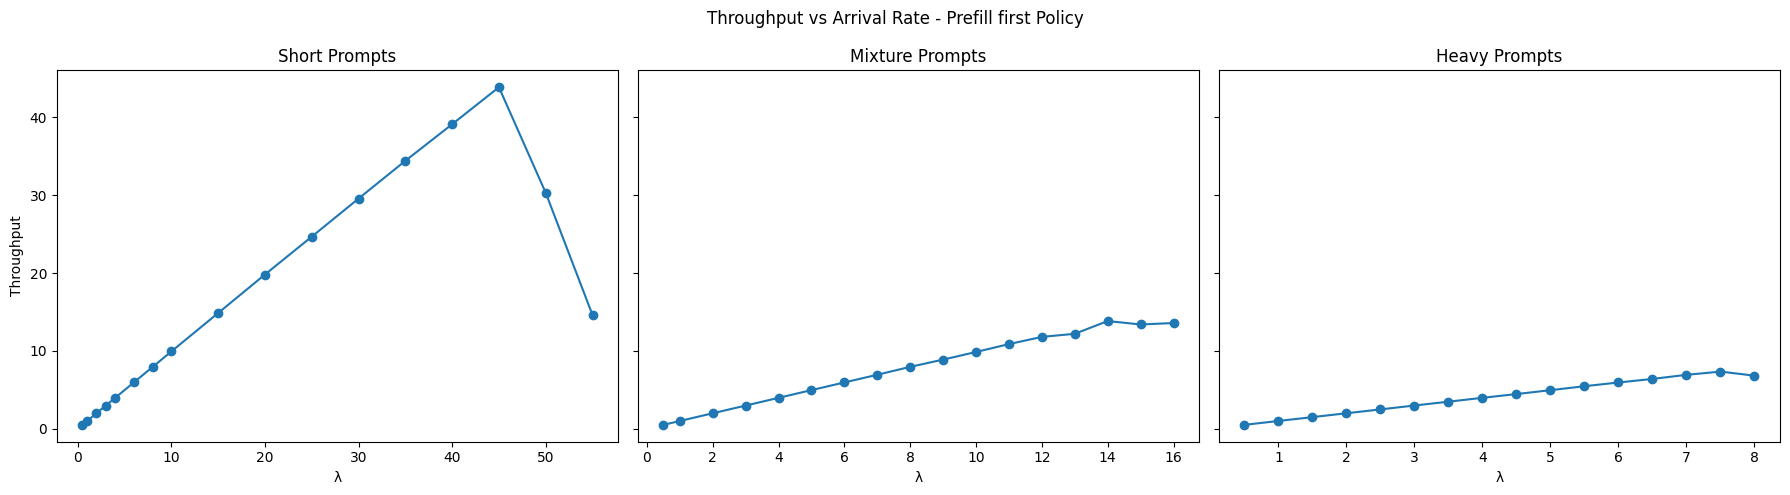

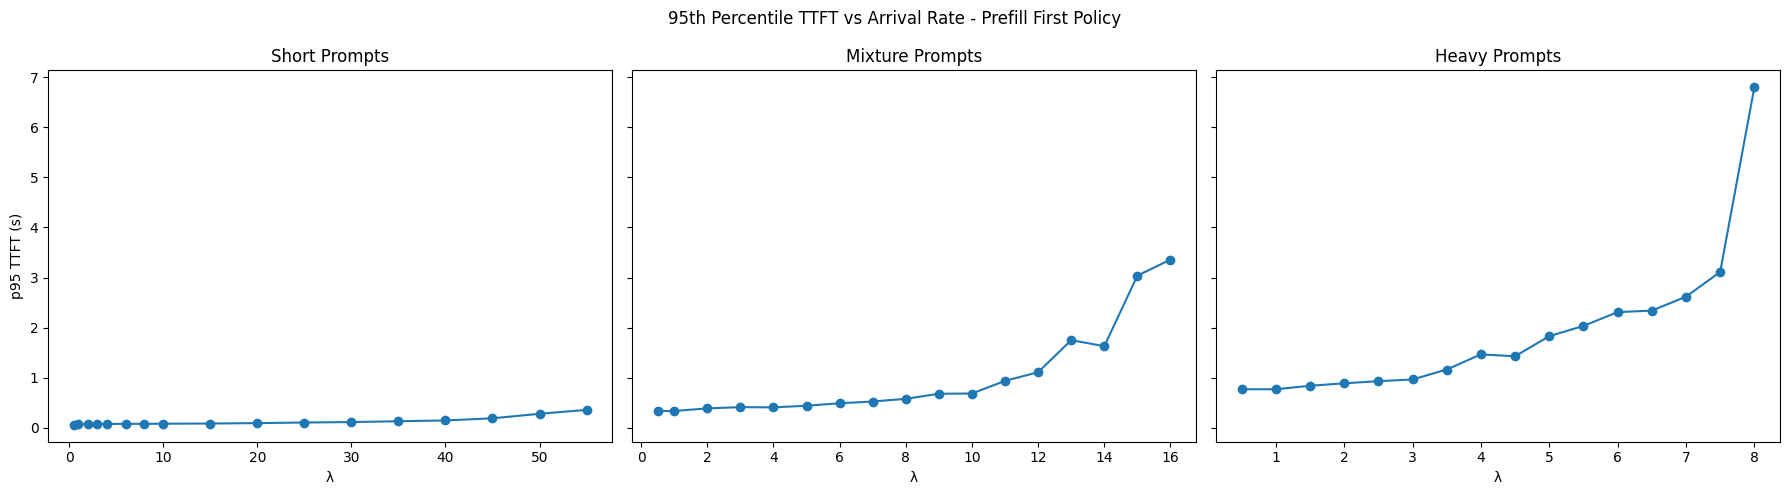

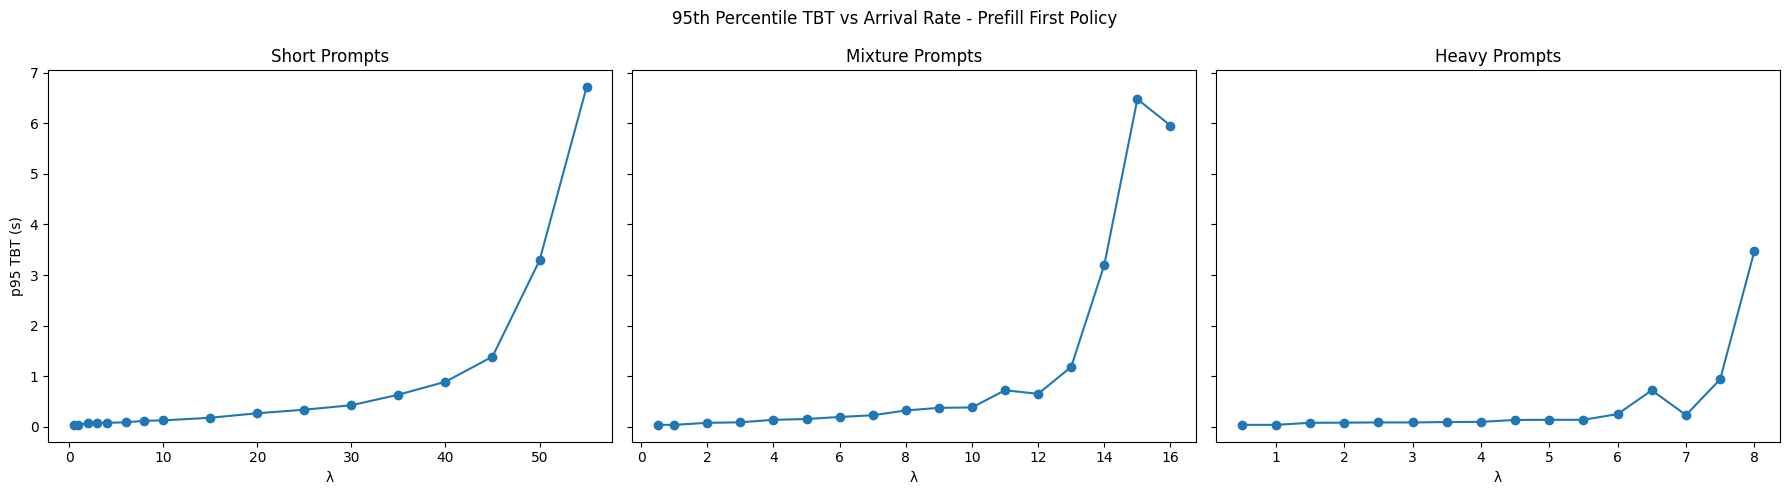

In [ ]:
#@title Plots For Prefill-First Policy

#Plots the results of analysis for prefill-first policy

#Throughput
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

axes[0].plot(df_short_pf["lambda"], df_short_pf["throughput"], marker="o")
axes[0].set_title("Short Prompts")
axes[0].set_xlabel("λ")
axes[0].set_ylabel("Throughput")

axes[1].plot(df_mixture_pf["lambda"], df_mixture_pf["throughput"], marker="o")
axes[1].set_title("Mixture Prompts")
axes[1].set_xlabel("λ")

axes[2].plot(df_heavy_pf["lambda"], df_heavy_pf["throughput"], marker="o")
axes[2].set_title("Heavy Prompts")
axes[2].set_xlabel("λ")

plt.suptitle("Throughput vs Arrival Rate - Prefill-first Policy")
plt.tight_layout()
plt.show()

#95th Percentile TTFT
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

axes[0].plot(df_short_pf["lambda"], df_short_pf["p95_ttft"], marker="o")
axes[0].set_title("Short Prompts")
axes[0].set_xlabel("λ")
axes[0].set_ylabel("p95 TTFT (s)")

axes[1].plot(df_mixture_pf["lambda"], df_mixture_pf["p95_ttft"], marker="o")
axes[1].set_title("Mixture Prompts")
axes[1].set_xlabel("λ")

axes[2].plot(df_heavy_pf["lambda"], df_heavy_pf["p95_ttft"], marker="o")
axes[2].set_title("Heavy Prompts")
axes[2].set_xlabel("λ")

plt.suptitle("95th Percentile TTFT vs Arrival Rate - Prefill-First Policy")
plt.tight_layout()
plt.show()

#95th Percentile TBT
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

axes[0].plot(df_short_pf["lambda"], df_short_pf["p95_tbt"], marker="o")
axes[0].set_title("Short Prompts")
axes[0].set_xlabel("λ")
axes[0].set_ylabel("p95 TBT (s)")

axes[1].plot(df_mixture_pf["lambda"], df_mixture_pf["p95_tbt"], marker="o")
axes[1].set_title("Mixture Prompts")
axes[1].set_xlabel("λ")

axes[2].plot(df_heavy_pf["lambda"], df_heavy_pf["p95_tbt"], marker="o")
axes[2].set_title("Heavy Prompts")
axes[2].set_xlabel("λ")

plt.suptitle("95th Percentile TBT vs Arrival Rate - Prefill-First Policy")
plt.tight_layout()
plt.show()

### Analysis

**Serve to Completion Policy**
For the serve-to-completion policy, throughput increases rapidly at low arrival rates and then plateaus across all three workloads, indicating that the GPU becomes fully utilized. Once this saturation point is reached, additional arrivals do not increase throughput and instead accumulate in the queue. Importantly, the arrival rate at which saturation occurs differs by workload: short workloads can sustain higher arrival rates before saturating, while mixture and heavy workloads reach saturation at much lower lambda values.<br>

The 95th-percentile TTFT increases as lambda rises across all three workloads, with tail TTFT increasing sharply at low lambda and then much more gradually at higher lambda over the tested range. The 95th-percentile TBT remains nearly constant across lambda for all workloads, which is expected since decoding proceeds at a fixed rate and is less sensitive to queueing effects under serve-to-completion.<br>

**Prefill-First Policy**
The prefill-first policy substantially improves performance at low to moderate arrival rates across all workloads. Under this policy, throughput is consistently higher than under serve-to-completion, especially for short prompts. In addition, 95th-percentile TTFT is significantly lower than under serve-to-completion, indicating that the system can tolerate higher arrival rates before experiencing large tail delays.<br>

However, as lambda continues to increase, the system exhibits a clear phase transition. Throughput begins to decline slightly for mixture and heavy workloads and sharply for low workload, while tail TTFT and TBT increase rapidly. This transition occurs at much lower arrival rates for the mixture and heavy workloads, where longer prompts and larger output budgets dominate GPU time and reduce the system’s ability to handle additional arrivals.<br>

###Conclusions
Across both policies, workload characteristics determine how much arrival load the system can withstand. Longer prompt lengths increase prefill time, while larger output budgets increase decode time, and together these factors determine how long each query occupies the GPU. As a result, heavy workloads reach saturation earlier and experience more severe degradation in both throughput and tail latency. Although the prefill-first policy delays the onset of these bottlenecks and allows the system to tolerate higher arrival rates under moderate load, it does not remove the fundamental capacity limit imposed by GPU utilization.


# **III. Changes in Batching Analysis**

### Modeling Approach, Assumptions, and Parameters
Batching occurs at the iteration level: at each GPU iteration, the scheduler forms a batch of jobs (either prefill work or decode tokens) subject to a maximum batch size K. The total token load in a batch is denoted by b, and batch service time is modeled using the piecewise-linear approximation: S(b) = c + a · max(0, b − b0). c represents a fixed setup cost per batch and 𝑎 a is the marginal cost per token beyond a threshold b0 . This captures the key empirical behavior of GPUs: small batches incur significant overhead, while larger batches achieve higher efficiency.


###Model Details
We compare three batching strategies: no batching, fixed batching and dynamic batching. In the no batching baseline, each job is processed individually, providing a reference point for validation. Fixed batching waits until a batch reaches a target size before dispatch. Dynamic batching forms batches opportunistically based on queue depth and waiting time.


**Figure 1** shows batch size distributions under the three strategies where fixed batching concentrates near the maximum batch size of K while dynamic batching produces a wider range of batch sizes. K was set to 32.


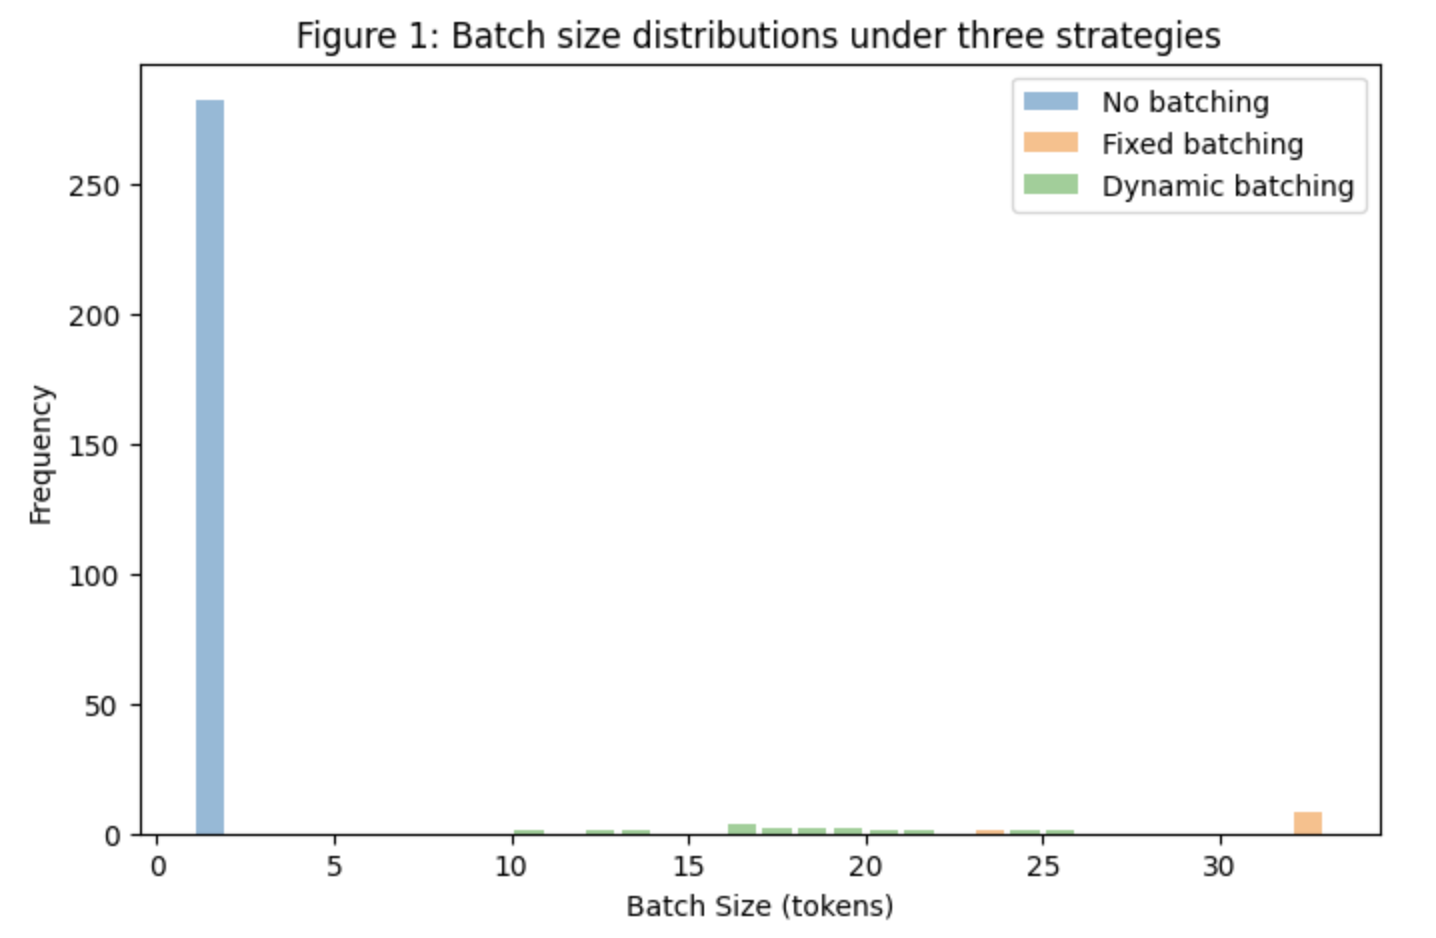

Batching is applied to both prefill and decode samples. Decode batches are constrained to include at most one token per query but may combine tokens from many queries. Prefill batches tend to be larger and more variable for token loads.

### Model Analysis
Batching substantially increases throughput by spreading the fixed setup cost over many tokens, allowing the GPU to spend a larger fraction of time doing useful computations rather than repeated setup work. Compared to no batching, both fixed and dynamic batching achieve higher query completion rates, particularly at moderate to high arrival rates.


**Figure 2** plots throughput as a function of batching strategy, demonstrating that fixed batching achieves the highest throughput followed closely by dynamic batching.


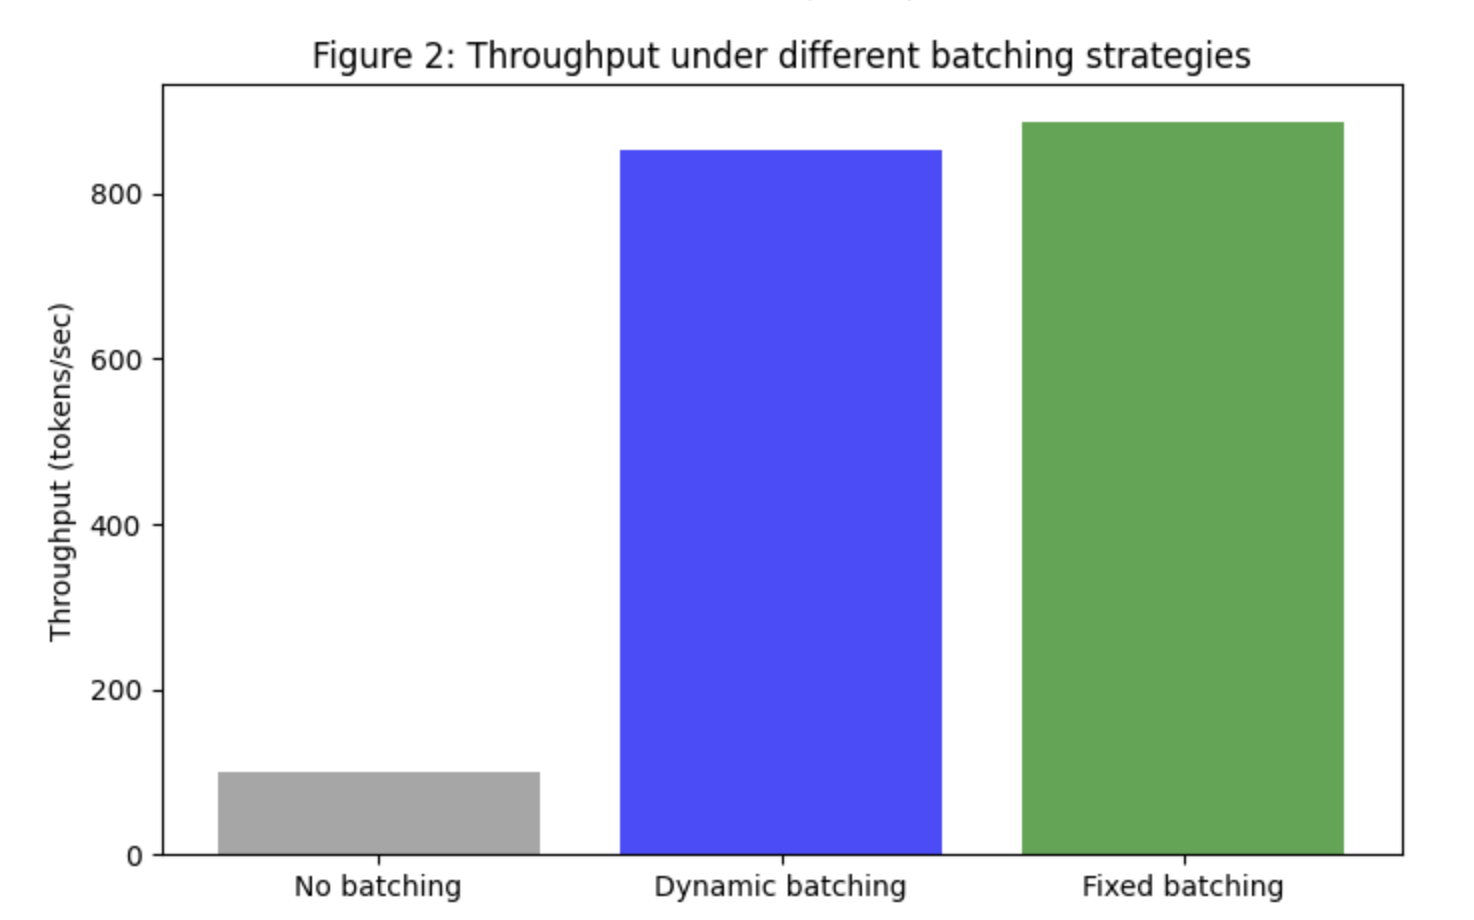

These throughput gains come at a latency cost. Fixed batching increases Time To First Token (TTFT) because queries may wait in the queue until a large batch forms. This effect is especially pronounced for short prompts.

**Figure 3** shows the mean and the 95th percentile TTFT for each batching strategy, where no batching exhibits significantly higher tail latency than dynamic and fixed batching.

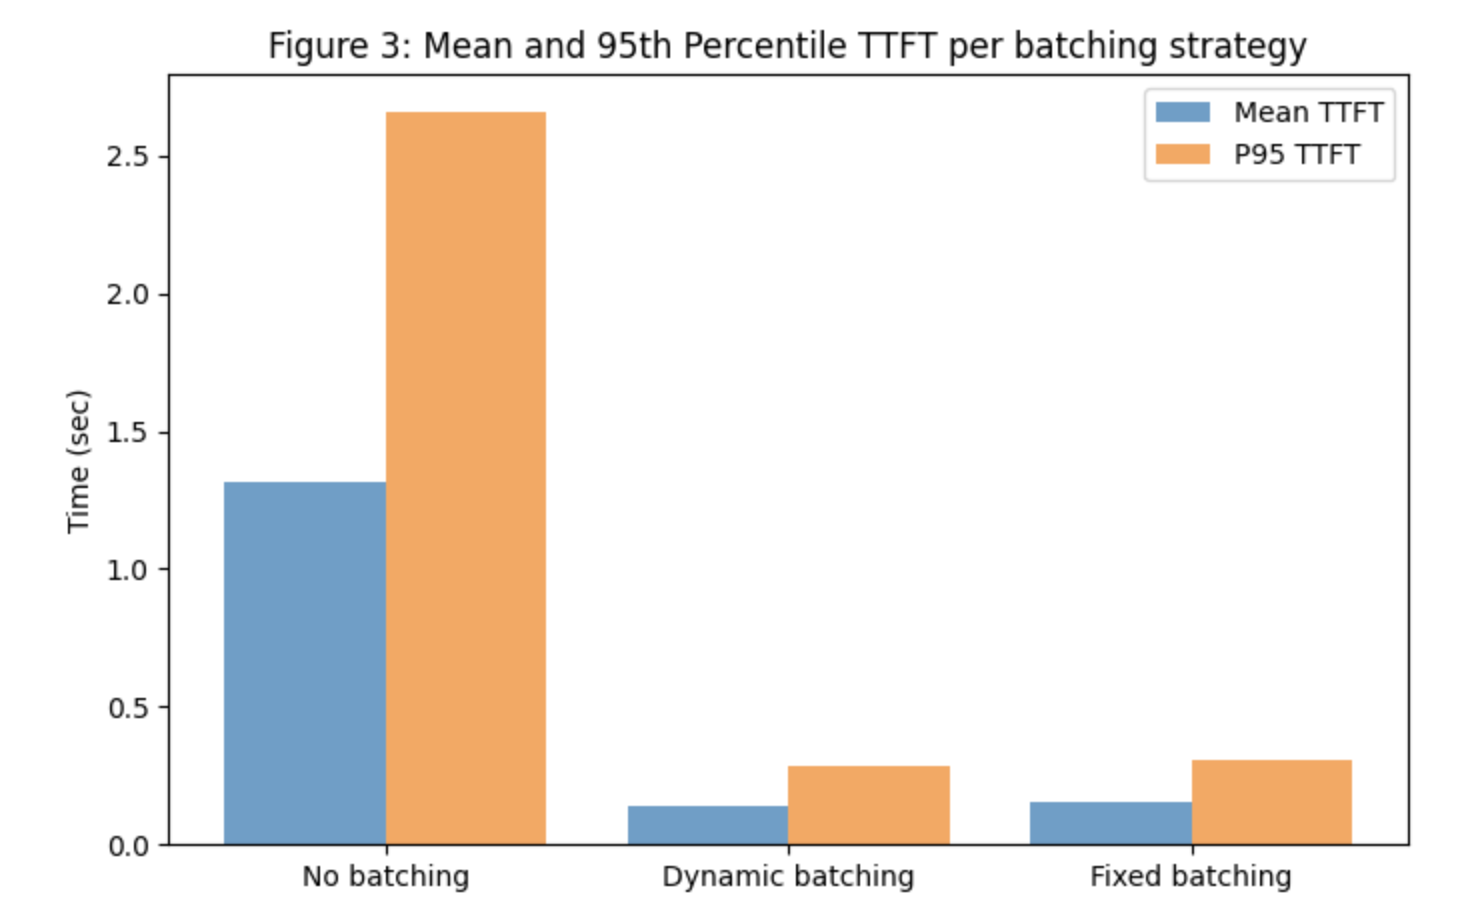

Decode performance shows a similar trade off. While batching improves TBT by keeping the GPU busy, aggressive prefill batching can delay decode iterations.


**Figure 4** presents the distribution of TBT, showing that dynamic batching reduces extreme delays while preserving most of the batching efficiency.


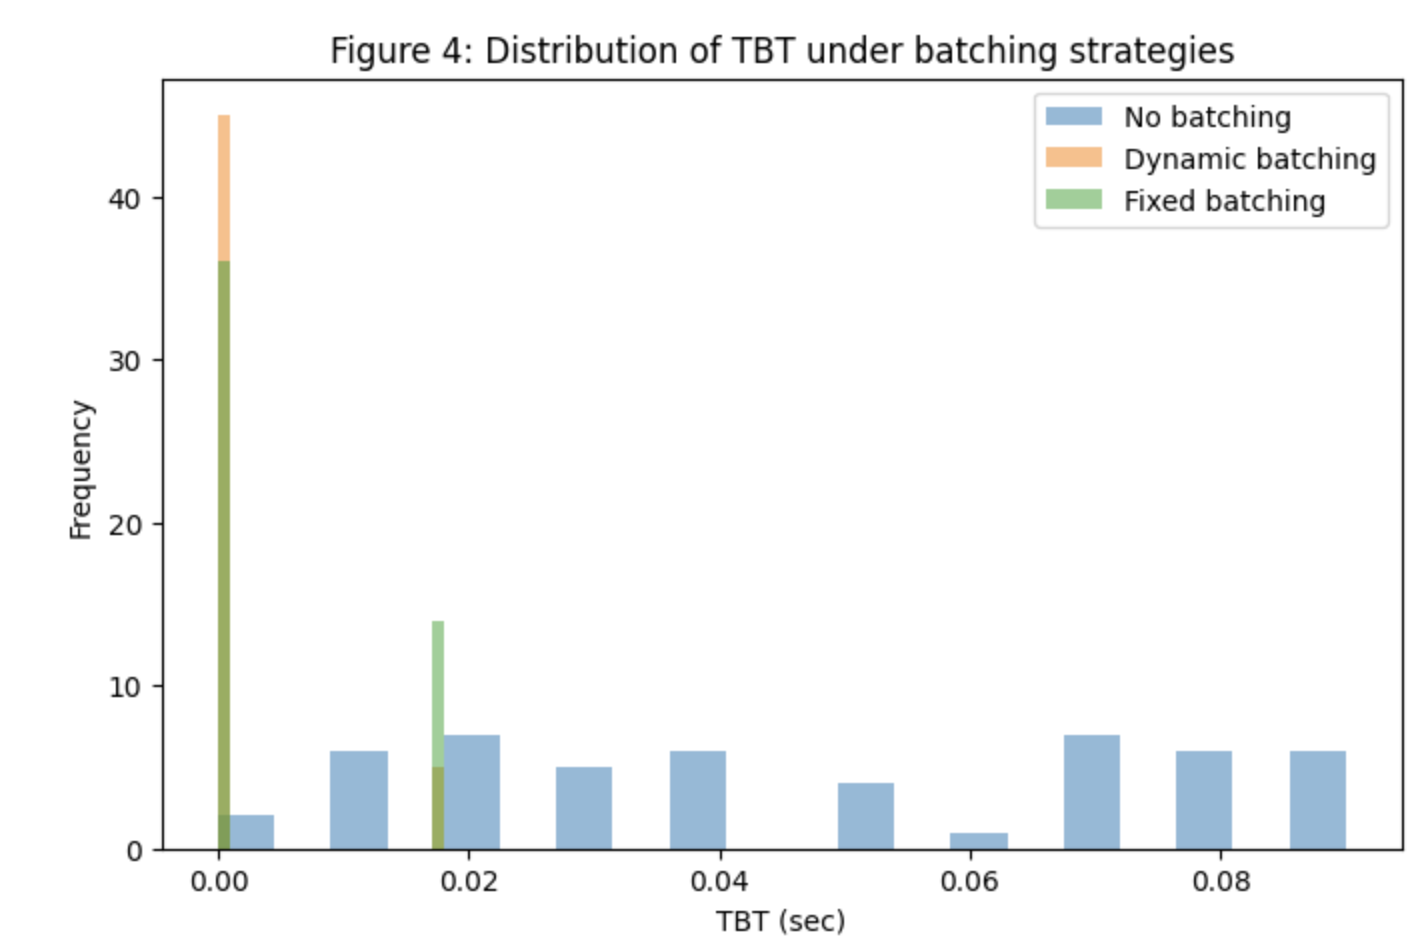

--2025-12-17 23:16:54--  https://raw.githubusercontent.com/sdevling/ORIE_4580_Final_Project/main/batching_testing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30068 (29K) [text/plain]
Saving to: ‘batching_testing.py.1’

batching_testing.py 100%[===================>]  29.36K  --.-KB/s    in 0.001s  

2025-12-17 23:16:54 (39.0 MB/s) - ‘batching_testing.py.1’ saved [30068/30068]



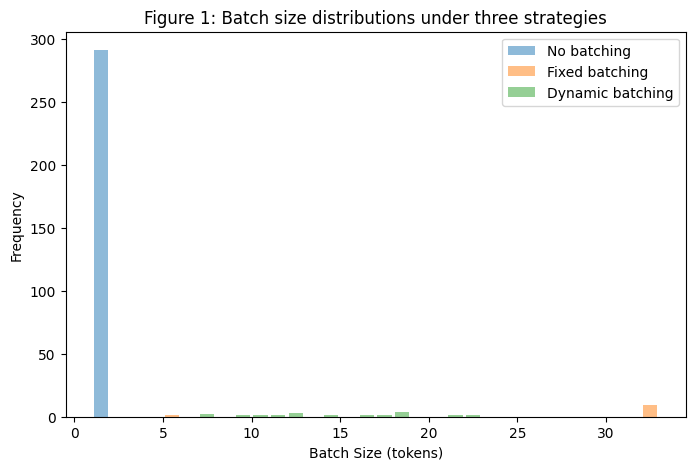

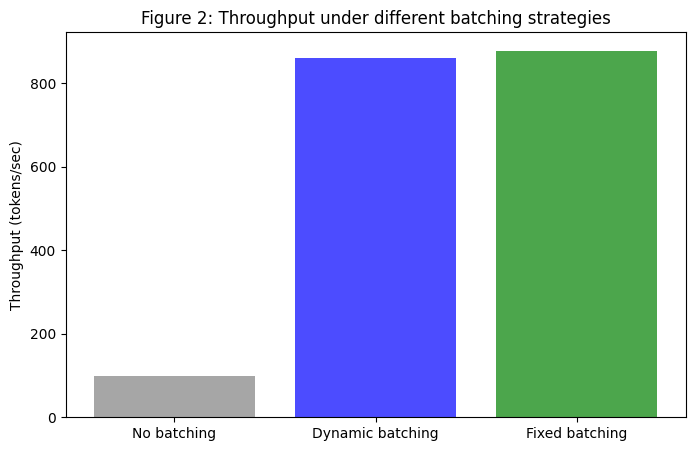

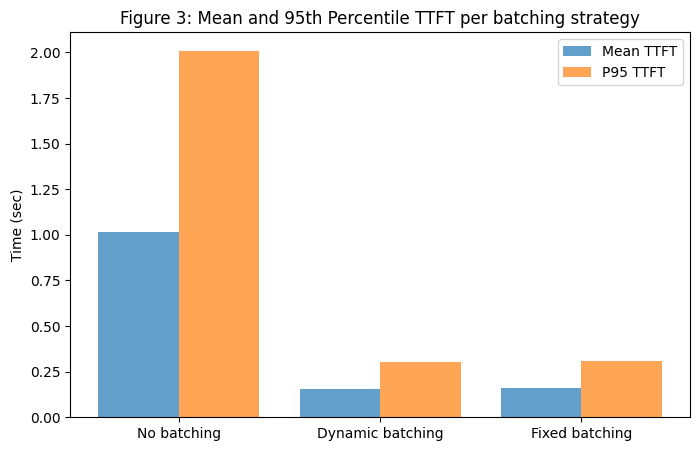

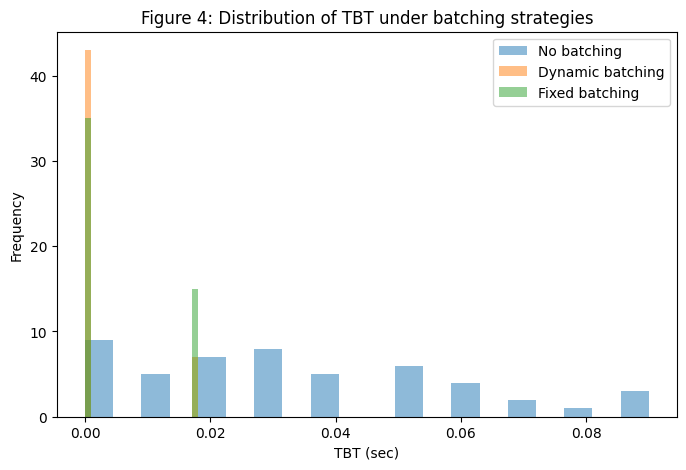

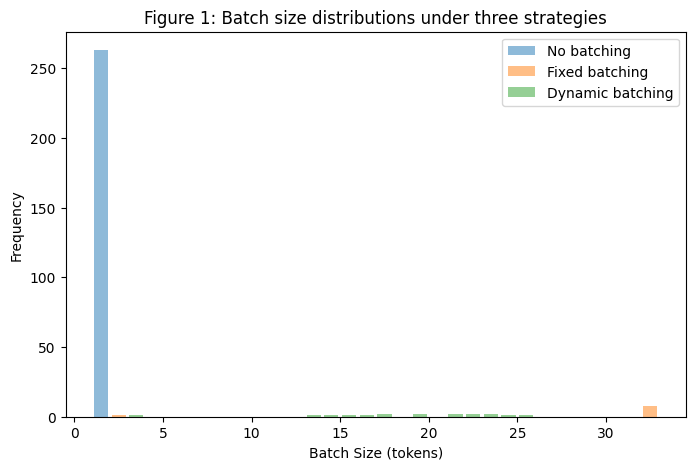

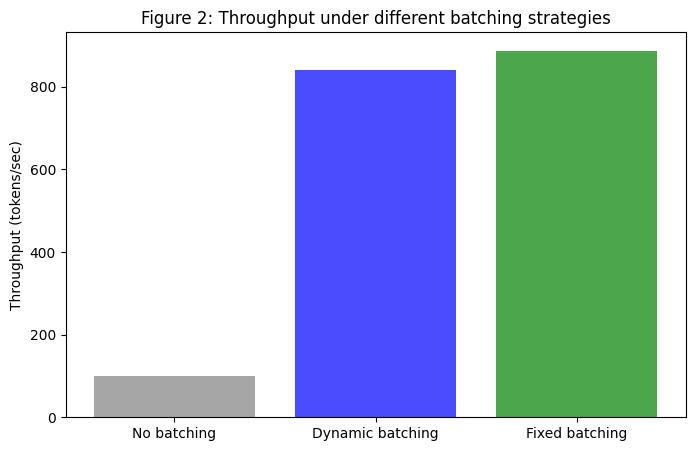

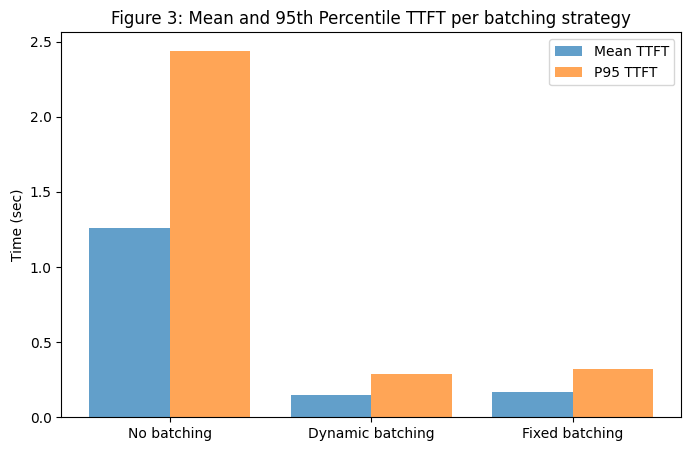

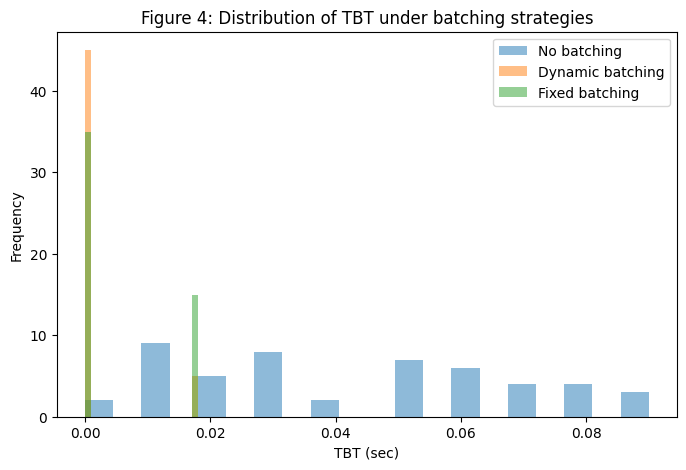

<module 'batching_testing' from '/content/batching_testing.py'>

In [ ]:
!wget https://raw.githubusercontent.com/sdevling/ORIE_4580_Final_Project/main/batching_testing.py
import batching_testing as demo
import importlib
importlib.reload(demo)

# **IV. Conclusion**

We have developed a stochastic simulation to study how scheduling and batching decisions shape the performance of LLM query-serving systems. The simulation allows us to study how these different decisions impact throughput, latency, and fairness under different workloads by modeling the prefill and decode stages of inference and capturing realistic GPU behavior. <br>

Our results show that scheduling policy has a major impact on system performance. Decode-prioritizing policies provide consistent token generation but as arrival rate increases, so does latency. Prefill-prioritizing policies are more effective at maintaining high throughput, especially for light and mixed workloads, but as the workload becomes heavier, an increase in delays in response generation may occur. Hybrid policies can be adjusted to balance throughput, latency, and fairness depending on the type of workload and performance objectives. Batching also plays an important role in system behavior. Batching improves efficiency by reducing repeated GPU setup costs, but large batches increase TTFT. However, dynamic batching maintains strong performance while limiting extreme delays, especially for shorter queries.<br>

Based on these findings, we recommend using prefill-prioritizing or hybrid scheduling policies when expecting high arrival rates and combining it with dynamic batching to reduce latency. Applications that prioritize low latency may benefit from smaller batch sizes or hybrid approaches configured for faster response times. As a next step, this simulation framework can be extended to study chunked prefill strategies, multi-GPU systems, and more realistic workload patterns. These extensions would provide additional insight into how modern LLM serving systems can be designed to scale efficiently while maintaining a responsive user experience.


# **Analytical Appendix**

### I. Steady state considerations

Due to the complexity of the code used, it was not feasible to run 10,000 queries of the simulation to ensure steady state for each lambda value. However, to validate accuracy at 3000 queries, 10,000 queries were run for 2 different lambda values and the results were compared with values obtained in the analysis above. It was concluded that all steady state values were similar. Although baseline ttft at $\lambda = 1$ was higher in the 10,000 queries simulation than the 3,000, both simulations indicated instability at the same point in time.

In [ ]:
url2 = "https://raw.githubusercontent.com/sdevling/ORIE_4580_Final_Project/main/policy_testing_results_10000.csv"
df_policy10000 = pd.read_csv(url2)
df_policy10000.head()

,Lambda,Baseline throughput,PrefillFirst throughput,Hybrid throughput,Baseline ttft,PrefillFirst ttft,Hybrid ttft,Baseline tbt,PrefillFirst tbt,Hybrid tbt
0,0.5,0.498612,0.498653,0.498655,1.353733,0.049832,1.090337,0.04,0.040811,0.04
1,1.0,0.747028,0.997230,0.997311,1692.739830,0.055291,1.021811,0.04,0.041641,0.04


In [ ]:
df_policy3000.head()

,Lambda,Baseline throughput,PrefillFirst throughput,Hybrid throughput,Baseline ttft,PrefillFirst ttft,Hybrid ttft,Baseline tbt,PrefillFirst tbt,Hybrid tbt
0,0.5,0.504219,0.504219,0.504217,1.363119,0.049807,1.058350,0.04,0.040817,0.04
1,1.0,0.719000,1.008141,1.008228,572.387750,0.055788,1.041478,0.04,0.041669,0.04
2,1.5,0.687350,1.511784,1.511781,1150.505167,0.058763,1.005558,0.04,0.042536,0.04
3,2.0,0.672548,2.015014,2.015207,1439.563875,0.059995,1.000353,0.04,0.043429,0.04
4,2.5,0.663904,2.517959,2.518279,1613.365544,0.061055,0.965386,0.04,0.044339,0.04


### II. Dataframe used in Part I: Comparing Different Scheduling Policies

In [ ]:
print(df_policy3000)

    Lambda  Baseline throughput  PrefillFirst throughput  Hybrid throughput  \
0      0.5             0.504219                 0.504219           0.504217   
1      1.0             0.719000                 1.008141           1.008228   
2      1.5             0.687350                 1.511784           1.511781   
3      2.0             0.672548                 2.015014           2.015207   
4      2.5             0.663904                 2.517959           2.518279   
5      3.0             0.658241                 3.020357           3.019969   
6      3.5             0.654254                 3.522374           3.522265   
7      4.0             0.651296                 4.024059           4.028218   
8      4.5             0.649013                 4.525903           4.527199   
9      5.0             0.647199                 5.026599           5.029533   
10     5.5             0.645722                 5.526612           5.531838   
11     6.0             0.644496                 6.02

### III. Dataframes used in Part 2: Workload Sensitivity Analysis

####Dataframe for serve to completion policy - light workload

In [ ]:
df_short_stc

,throughput,p95_ttft,p95_tbt,lambda,workload
0,0.495994,0.941506,0.04,0.5,short
1,0.991971,1.636999,0.04,1.0,short
2,1.978173,4.088482,0.04,2.0,short
3,2.572525,183.699172,0.04,3.0,short
4,2.581012,452.014409,0.04,4.0,short
5,2.505332,771.965513,0.04,6.0,short
6,2.381356,974.939220,0.04,8.0,short
7,2.453315,1029.699733,0.04,10.0,short
8,2.422524,1164.129732,0.04,15.0,short
9,2.354192,1250.673777,0.04,20.0,short


####Dataframe for serve to completion policy - mixed workload

In [ ]:
df_mixture_stc


,throughput,p95_ttft,p95_tbt,lambda,workload
0,0.495948,0.928000,0.04,0.5,mixture
1,0.991809,1.595047,0.04,1.0,mixture
2,1.983227,4.654176,0.04,2.0,mixture
3,2.689326,126.830034,0.04,3.0,mixture
4,2.569360,460.153067,0.04,4.0,mixture
5,2.479776,672.303232,0.04,5.0,mixture
6,2.495410,769.263870,0.04,6.0,mixture
7,2.467391,875.063634,0.04,7.0,mixture
8,2.461850,938.532165,0.04,8.0,mixture
9,2.437146,1001.655585,0.04,9.0,mixture


####Dataframe for serve to completion policy - heavy workload

In [ ]:
df_heavy_stc

,throughput,p95_ttft,p95_tbt,lambda,workload
0,0.496008,0.928000,0.04,0.5,heavy
1,0.991926,1.360903,0.04,1.0,heavy
2,1.487814,2.060086,0.04,1.5,heavy
3,1.983921,4.056954,0.04,2.0,heavy
4,2.470912,15.404216,0.04,2.5,heavy
5,2.674537,128.958400,0.04,3.0,heavy
6,2.679124,282.887412,0.04,3.5,heavy
7,2.588875,442.645347,0.04,4.0,heavy
8,2.589649,541.940584,0.04,4.5,heavy
9,2.517544,640.937703,0.04,5.0,heavy


####Dataframe for prefill-first policy - light workload

In [ ]:
df_short_pf

,throughput,p95_ttft,p95_tbt,lambda,workload
0,0.495998,0.058990,0.0400,0.5,short
1,0.991929,0.068384,0.0400,1.0,short
2,1.983880,0.074345,0.0800,2.0,short
3,2.975753,0.075489,0.0800,3.0,short
4,3.965014,0.077281,0.0800,4.0,short
5,5.951167,0.078417,0.0896,6.0,short
6,7.929501,0.079473,0.1200,8.0,short
7,9.920475,0.081675,0.1275,10.0,short
8,14.856988,0.085567,0.1801,15.0,short
9,19.804043,0.093199,0.2688,20.0,short


####Dataframe for prefill-first policy - mixed workload

In [ ]:
df_mixture_pf

,throughput,p95_ttft,p95_tbt,lambda,workload
0,0.495992,0.336000,0.040000,0.5,mixture
1,0.991861,0.336000,0.040000,1.0,mixture
2,1.983925,0.387222,0.080000,2.0,mixture
3,2.973589,0.412266,0.090515,3.0,mixture
4,3.966123,0.407500,0.139200,4.0,mixture
5,4.959747,0.440623,0.155100,5.0,mixture
6,5.943176,0.489521,0.196000,6.0,mixture
7,6.931654,0.524840,0.229100,7.0,mixture
8,7.946917,0.578513,0.324100,8.0,mixture
9,8.878360,0.679604,0.376000,9.0,mixture


####Dataframe for prefill-first policy - heavy workload

In [ ]:
df_heavy_pf

,throughput,p95_ttft,p95_tbt,lambda,workload
0,0.495998,0.769600,0.04000,0.5,heavy
1,0.991700,0.769625,0.04000,1.0,heavy
2,1.487910,0.839194,0.08000,1.5,heavy
3,1.983479,0.888000,0.08300,2.0,heavy
4,2.478598,0.931220,0.08750,2.5,heavy
5,2.978563,0.964536,0.08720,3.0,heavy
6,3.471296,1.163688,0.09500,3.5,heavy
7,3.967401,1.465952,0.09860,4.0,heavy
8,4.450731,1.428407,0.13680,4.5,heavy
9,4.947743,1.829860,0.13920,5.0,heavy


# **Technical Appendix: Simulation Base Model Implementation Details**

###A.1 Simulator Overview

We implement a simulation of LLM query serving system with a single GPU worker. The simulator models query arrivals, scheduling decisions, GPU batch execution and query level latency metrics. Time advances only at event boundaries which are query arrivals or batch completions.

```python
simulate(policy, *, n_queries, warmup, lam, L, B, c_ms, a_ms, b0, K, seed)

This system models a single GPU processing LLM queires under a specified scheduling policy. Simulation time advances at event boudnaries which are
- query arrival events
- GPU batch completion events


###A.2 Query Representation
Each query is reperesented by the following class

```python
@dataclass
class Query:
    id: int
    arrival_time: float
    L: int
    B: int
    prefill_done: int = 0
    decode_done: int = 0
    ttft_time: float | None = None
    completion_time: float | None = None
    last_decode_finish: float | None = None

Field meanings:
- id: identifier for query
- arrival_tikme: Time query arrives
- L: Prompt length of query
- B: Max response length of query
- prefill_done: Number of prefill tokens completed
- decode_done: Number of decode tokens completed
- ttft_time: Time prefill completed
- completion_time: Simulation time when query's last token is completed
- last_decode_finish: Time of last decode token


###A.3 Arrival Process
Query arrivals follow a possion process with rate lam (queries per second). Interarrival times are sampled as

```python
next_arrival = rng.exponential(1 / lam)

When a query arrives:
- a new Query object is created
- appended to prefill_queue
- next arrival time is scheduled

###A.4 Queues and Sate Invariants
The simulatior maintains two queues:

```python
prefill_queue: List[Query]
decode_queue: List[Query]

The queues satisfy the following invariants:
- prefill_queue contains exactly the queires when prefill done < L
- decode_queue contains exactly the queries with prefill_done >= L and decode_done < B

###A.5 Service Model
Batch service time depends on the total number of tokens processed in the batch. The service model is

```python
def service_time(token_load: int, c: float, a: float, b0: int) -> float:
    return c + a * max(0, token_load - b0)

Parameters:
- c and a are provided in milliseconds and converted to seconds
- b0 is the breakpoint token threshold
- token_load is the sum of tokens across batch items

###A.6 Scheduling Polices
####A.6.1 Serve to Completion Policy
- earliest arriving query among all query
- process that query exclusilvey until completion
- prefill tokens processed in batch size of min(remaining,K)
- decode tokens are processed one token per batch
- no batching acorss multiple queries occurs
GPU alwasy contains exactly one (query, n-tokens, phase) tuple
####A.6.2 Prefill-First Policy
- if any prefill work exists, the polcy forms a prefill batch
- prefill batch are constructed by iterating through earliest arrivaing queries and taking as many tokens as possible until batch reaches capacity K
- if no prefill work exists, a decode batch is constructed
- decode batches include at most one token per query
- total tokens never exeed K


###A.7 Event Loop and Time Advancement
The simulation advances time by using

```python
candidate_times = [next_arrival]
if gpu_busy_until is not None:
    candidate_times.append(gpu_busy_until)

t_next = min(candidate_times)
t = t_next

####A7.1 Arrival Event(t==next_arrival)
When an arrival occurs, simulator creates a new query and appends it to prefill queue

```python
q = Query(id=len(all_queries), arrival_time=t, L=L, B=B)
all_queries.append(q)
prefill_queue.append(q)

next_arrival = t + rng.exponential(1 / lam)

If GPU in idle:

```python
if gpu_busy_until is None:
    try_dispatch()

####A7.2 Batch Completion Event(t==gpu_busy_until)
When GPU finishes active batch, then apply batch results, update metrics, and dispatch next

```python
gpu_busy_until = None

before = len(metrics["completion"])

apply_batch_completion(
    t,
    active_batch,
    prefill_queue,
    decode_queue,
    warmup_id=warmup,
    metrics=metrics,
)

after = len(metrics["completion"])
completed_after_warmup += (after - before)

try_dispatch()

###A.8 Batch Completion Update


```python
apply_batch_completion(t, batch, prefill_queue, decode_queue, warmup_id, metrics)


####A8.1 Prefill Phase Updates

```python
q.prefill_done += n_tokens


When finishes for the first time record TTFT

```python
if q.prefill_done >= q.L and q.ttft_time is None:
    q.ttft_time = t
    if q.id >= warmup_id:
        metrics["ttft"].append(q.ttft_time - q.arrival_time)
    if q not in decode_queue:

####A8.2 Decode Phase Updates

```python
q.decode_done += n_tokens

Time between tokens is computed using the previous decode finish time

```python
if q.last_decode_finish is not None:
    metrics["tbt"].append(t - q.last_decode_finish)
    metrics["tbt_time"].append(t)
q.last_decode_finish = t

When decode finishes we record end to end completion time

```python
if q.decode_done >= q.B and q.completion_time is None:
    q.completion_time = t
    if q.id >= warmup_id:
        metrics["completion"].append(q.completion_time - q.arrival_time)

###A.9 Warmup and Stopping Conditions
The first warmup queries are ignored in metrics as metrics only record when

```python
if q.id >= warmup_id:

and simulation stops after completing n_queries





```python
target_completed = n_queries - warmup
while completed_after_warmup < target_completed:

###A.10 Throughput Computation
After simulation ends throughput is computed from post warmup completed queries

```python
post = [q for q in all_queries if q.id >= warmup and q.completion_time is not None]
    post.sort(key=lambda q: q.completion_time)

    if len(post) >= 2:
        elapsed = post[-1].completion_time - post[0].arrival_time
        throughput = len(post) / elapsed if elapsed > 0 else float("nan")
    else:
        throughput = float("nan")

###A.11 Returned Outputs
The simulatior returns:

```python
return {
        "throughput": throughput,
        "ttft": np.array(metrics["ttft"]),
        "ttft_time": np.array(metrics["ttft_time"]),
        "tbt": np.array(metrics["tbt"]),
        "tbt_time": np.array(metrics["tbt_time"]),
        "completion": np.array(metrics["completion"]),
    }

###A.12 Validation

We validate the simulator by using a load sweep algorthim, where we vary the query arrival rate lamanda and estimate the average number of queries in the system using Little's Law. For each value of lambda we run the simulator to steady stat, comput the mean end to end completion time W from post warmup queries and estimate the effective arrival rate using measured throughput.

The resulting plot shows that L remains small at low arrival rates, indicating stable operation with minimial queueing. As lambda approaces the system's effective capacity, then L increases sharply signgally a phase transistion from stable to overloaded. The behavior is consistent with standard queuing theory and provides evidene that the simularot correclty captures queue buildup, capacity limits, and event driven dynamics.

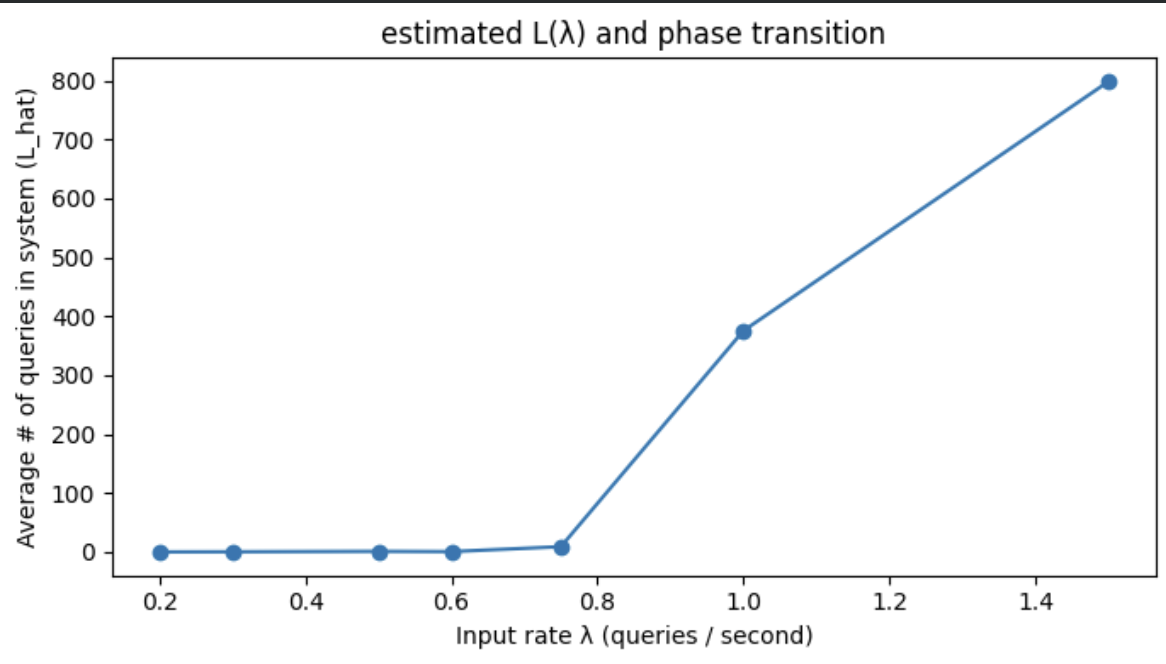